# Data quality

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats




from fault_management_uds.data.load import import_external_metadata, import_metadata
from fault_management_uds.data.hdf_functions import load_dataframe_from_HDF5, print_tree
from fault_management_uds.data.process import remove_nans_from_start_end


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR
from fault_management_uds.config import natural_sensor_order, natural_structure_order, structure_2_sensor, rain_gauges
from fault_management_uds.config import bools_2_meta, error_indicators, sensor_2_alias, indicator_2_meta

seed = 42
np.random.seed(seed)


2024-11-17 13:52:50.379 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [2]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'

f = print_tree(data_file_path)

root
├── combined_data
│   ├── clean
│   │   ├── columns
│   │   ├── data
│   │   └── timestamps
│   └── raw
│       ├── columns
│       ├── data
│       └── timestamps
└── single_series
    ├── rain_gauge_data
    │   ├── 5425
    │   │   ├── columns
    │   │   ├── data
    │   │   └── timestamps
    │   └── 5427
    │       ├── columns
    │       ├── data
    │       └── timestamps
    └── sewer_data
        ├── G71F04R_Level1
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   └── raw
        │       ├── columns
        │       ├── data
        │       └── timestamps
        ├── G71F04R_Level2
        │   ├── bools
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │   ├── clean
        │   │   ├── columns
        │   │   ├── data
        │   │   └── timestamps
        │ 

In [3]:
# for sensor and raw value file, check total average value, and average when positive
metadata = import_metadata(REFERENCE_DIR / 'external_metadata.csv')
sensor_metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')
raw_sensor_path = RAW_DATA_DIR / 'Bellinge' / 'sensor-data'
provided_processed_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'sensor-data' / '2_cleaned_data'


scripts_path = EXTERNAL_DATA_DIR / 'Bellinge' / 'scripts'
external_metadata, manual_remove = import_external_metadata(scripts_path)


In [4]:
starttime = metadata['StartTime'].min()
endtime = metadata['EndTime'].max()

print(f"Start time: {starttime}")
print(f"End time: {endtime}")

Start time: 2010-01-01 00:00:00
End time: 2021-08-19 00:00:00


In [5]:
save_folder = FIGURES_DIR / 'analysis' / 'data_quality'
os.makedirs(save_folder, exist_ok=True)

## Histogram of lengths of un/interrupted data segments

In [6]:
# load data
clean, _, _, _ = load_dataframe_from_HDF5(data_file_path, 'combined_data/clean', 
    columns=natural_sensor_order, starttime=starttime, endtime=endtime
    )


In [7]:
durations = {}
# use ideas from the error analysis script?
for sensor_name in tqdm(natural_sensor_order, total=len(natural_sensor_order)):
    durations[sensor_name] = {
        'Valid Segments': [],
        'Invalid Segments': [],
    }
    # get the sensor meta
    meta = external_metadata[external_metadata['IdMeasurement'] == sensor_name]
    for i, _meta in meta.iterrows():
        starttime = _meta['StartTime']
        endtime = _meta['EndTime']
        # filter
        sensor_data = clean.loc[starttime:endtime, sensor_name].copy().to_frame()
        sensor_data = remove_nans_from_start_end(sensor_data, sensor_name)

        # Identify non-NaN periods, i.e. values go from NaN to non-NaN or non-NaN to NaN
        sensor_data['non_nan_group'] = (sensor_data[sensor_name].notna() != sensor_data[sensor_name].notna().shift()).cumsum()
        # Valid:
        # Filter out NaN periods, keep only non-NaN groups
        non_nan_periods = sensor_data[sensor_data[sensor_name].notna()]
        # Calculate the size of each non-NaN period
        period_lengths = non_nan_periods.groupby('non_nan_group').size()
        # Save the valid and invalid segments
        durations[sensor_name]['Valid Segments'].extend(period_lengths[period_lengths >= 1].tolist())
        
        # Invalid:
        nan_periods = sensor_data[sensor_data[sensor_name].isna()]
        period_lengths = nan_periods.groupby('non_nan_group').size()
        durations[sensor_name]['Invalid Segments'].extend(period_lengths[period_lengths >= 1].tolist())

100%|██████████| 19/19 [00:05<00:00,  3.28it/s]


for each sensor, valid and invalid side by side

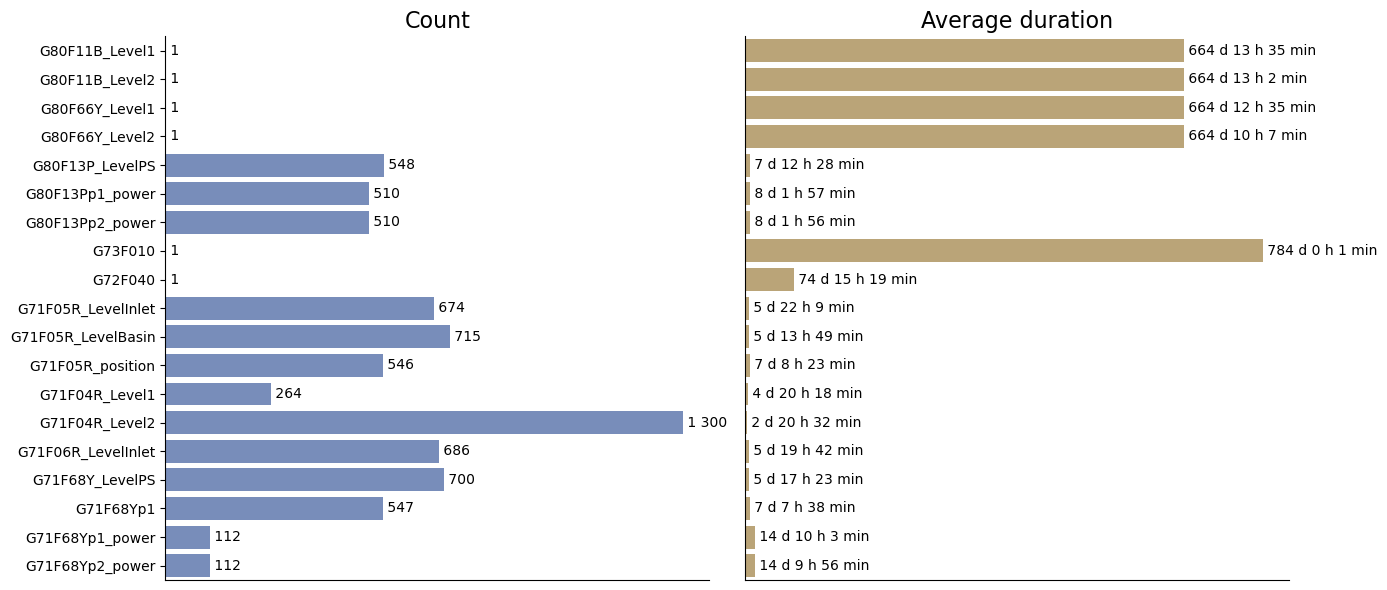

In [8]:
# Plot with error bars
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#5671A9', '#A98E56']
for sensor in natural_sensor_order:
    # left is valid, right is invalid
    for i, operation in enumerate(['count', 'average duration']):

        if operation == 'count':
            number = len(durations[sensor]['Valid Segments'])
            formatted_number = f" {number:,}".replace(',', ' ')
        
        else:
            if len(durations[sensor]['Valid Segments']) == 0:
                number = 0
            else:
                number = np.mean(durations[sensor]['Valid Segments'])
            # Add text to the bars
            days = number // (60 * 24)
            remaining_minutes = number % (60 * 24)
            hours = remaining_minutes // 60
            minutes = remaining_minutes % 60
            # convert to integer
            days, hours, minutes = int(days), int(hours), int(minutes)
            if days > 0:
                formatted_number = f" {days:,} d {hours} h {minutes} min"
            elif hours > 0:
                formatted_number = f" {hours:,} h {minutes} min"
            else:
                formatted_number = f" {minutes} min"
            formatted_number = formatted_number.replace(',', ' ')

        ax = axs[i]
        ax.set_title(operation.capitalize(), fontsize=16)
        ax.barh(
            sensor, 
            number,
            capsize=5,  # Add caps to the error bars
            color=colors[i],
            alpha=0.8,
        )

        ax.text(number, sensor, formatted_number, ha='left', va='center')



# remove y ticks on right plot
axs[1].set_yticks([])

for ax in axs:
    # Remove the top and right spines from plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    # and x axis ticks
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    # fit y axis range
    ax.set_ylim(-0.5, len(natural_sensor_order) - 0.5)
    # invert y axis
    ax.invert_yaxis()

plt.tight_layout()
# Save the figure
plt.savefig(save_folder / 'valid_segments.png', bbox_inches='tight')
plt.show()

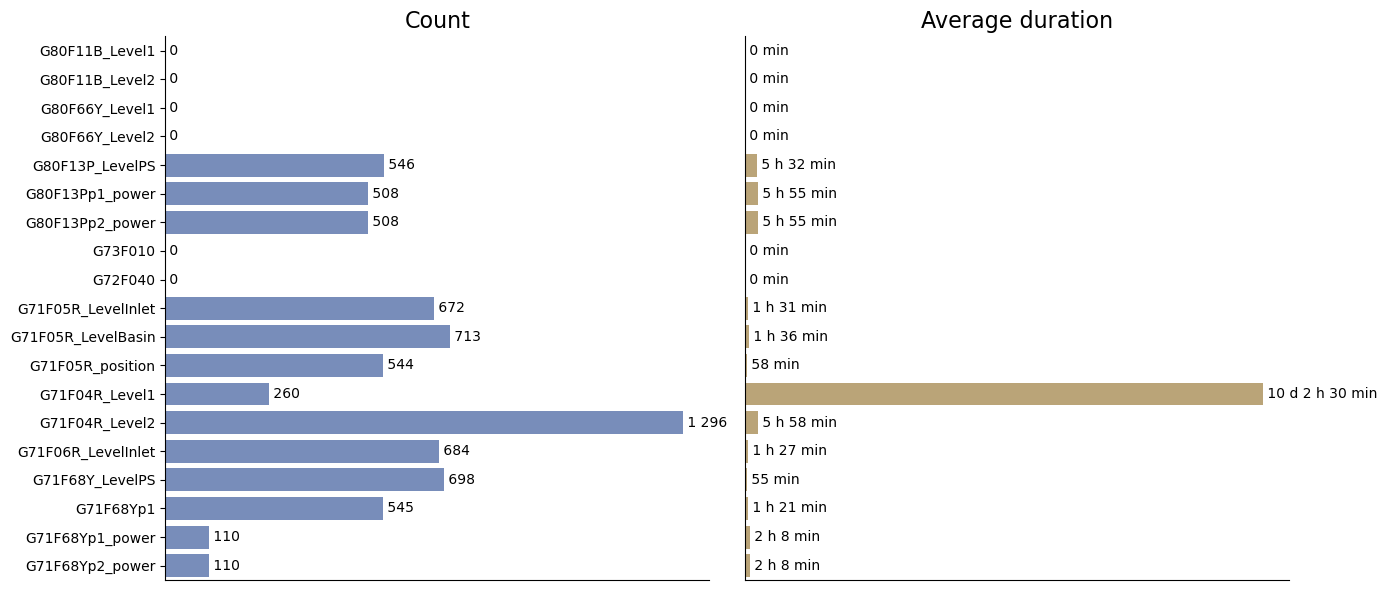

In [9]:
# Plot with error bars
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

colors = ['#5671A9', '#A98E56']
for sensor in natural_sensor_order:
    # left is valid, right is invalid
    for i, operation in enumerate(['count', 'average duration']):

        if operation == 'count':
            number = len(durations[sensor]['Invalid Segments'])
            formatted_number = f" {number:,}".replace(',', ' ')
        
        else:
            if len(durations[sensor]['Invalid Segments']) == 0:
                number = 0
            else:
                number = np.mean(durations[sensor]['Invalid Segments'])
            # Add text to the bars
            days = number // (60 * 24)
            remaining_minutes = number % (60 * 24)
            hours = remaining_minutes // 60
            minutes = remaining_minutes % 60
            # convert to integer
            days, hours, minutes = int(days), int(hours), int(minutes)
            if days > 0:
                formatted_number = f" {days:,} d {hours} h {minutes} min"
            elif hours > 0:
                formatted_number = f" {hours:,} h {minutes} min"
            else:
                formatted_number = f" {minutes} min"
            formatted_number = formatted_number.replace(',', ' ')

        ax = axs[i]
        ax.set_title(operation.capitalize(), fontsize=16)
        ax.barh(
            sensor, 
            number,
            capsize=5,  # Add caps to the error bars
            color=colors[i],
            alpha=0.8,
        )

        ax.text(number, sensor, formatted_number, ha='left', va='center')



# remove y ticks on right plot
axs[1].set_yticks([])

for ax in axs:
    # Remove the top and right spines from plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    # and x axis ticks
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    # fit y axis range
    ax.set_ylim(-0.5, len(natural_sensor_order) - 0.5)
    # invert y axis
    ax.invert_yaxis()

plt.tight_layout()
# Save the figure
plt.savefig(save_folder / 'invalid_segments.png', bbox_inches='tight')
plt.show()

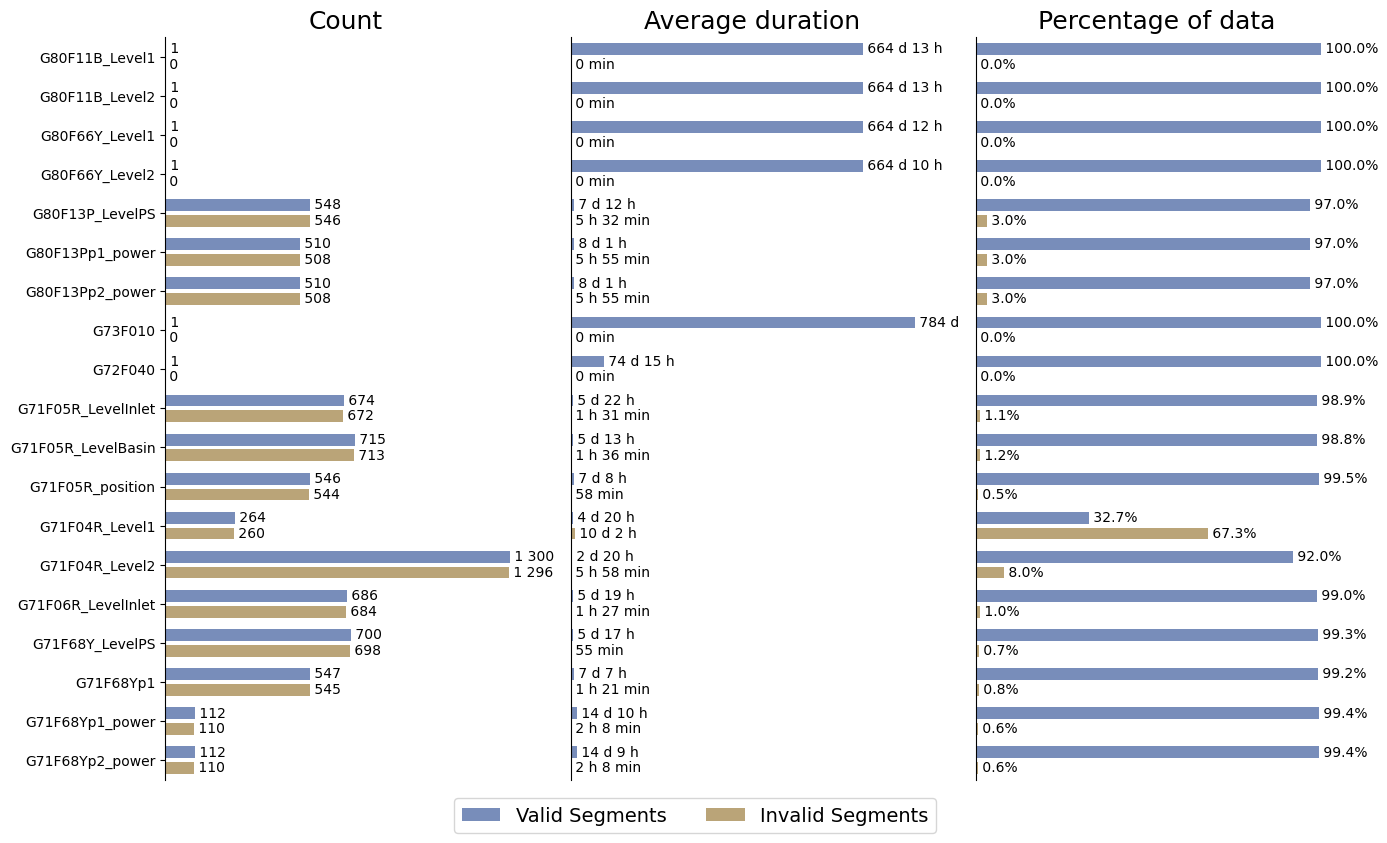

In [16]:
# Plot with error bars
fig, axs = plt.subplots(1, 3, figsize=(14, 8))

colors = ['#5671A9', '#A98E56']
segment_types = ['Valid Segments', 'Invalid Segments']

for sensor_index, sensor in enumerate(natural_sensor_order):
    for i, operation in enumerate(['count', 'average duration', 'percentage of data']):
        for j, segment_type in enumerate(segment_types):
            if operation == 'count':
                number = len(durations[sensor][segment_type])
                formatted_number = f" {number:,}".replace(',', ' ')
            elif operation == 'average duration':
                if len(durations[sensor][segment_type]) == 0:
                    number = 0
                else:
                    number = np.mean(durations[sensor][segment_type])
                days = number // (60 * 24)
                remaining_minutes = number % (60 * 24)
                hours = remaining_minutes // 60
                minutes = remaining_minutes % 60
                days, hours, minutes = int(days), int(hours), int(minutes)
                if days > 0:
                    #formatted_number = f" {days:,} d {hours} h {minutes} min"
                    formatted_number = f" {days:,} d"
                    if hours > 0:
                        formatted_number += f" {hours} h"

                elif hours > 0:
                    formatted_number = f" {hours:,} h {minutes} min"
                else:
                    formatted_number = f" {minutes} min"
                formatted_number = formatted_number.replace(',', ' ')
            else:
                if len(durations[sensor][segment_type]) == 0:
                    number = 0
                else:
                    number = sum(durations[sensor][segment_type]) / (sum(durations[sensor]['Valid Segments']) + sum(durations[sensor]['Invalid Segments'])) * 100
                formatted_number = f" {number:.1f}%"
            ax = axs[i]
            ax.set_title(operation.capitalize(), fontsize=18)
            # Use sensor index to position bars
            adjust_j = j - 0.5
            adj = 0.1
            adjust_j = adjust_j + adj if j == 0 else adjust_j - adj
            ax.barh(
                sensor_index * 2 + adjust_j,  # Adjust for double the sensors
                number,
                # adjust width of the bars
                height=0.6,
                color=colors[j],
                alpha=0.8,
                label=segment_type if sensor_index == 0 else ""  # Add label only once for legend
            )

            ax.text(number, sensor_index * 2 + adjust_j, formatted_number, ha='left', va='center')

# Add legend to the first subplot, invert the order of the legend
handles, labels = axs[0].get_legend_handles_labels()
# Reverse the order of handles and labels
handles = handles#[::-1]
labels = labels#[::-1]
# Create the legend with the reversed order
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, -0.06))

for i, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_ylim(-1, len(natural_sensor_order) * 2 - 1)
    ax.invert_yaxis()
    # Set y-ticks to sensor names centered
    if i==0:
        ax.set_yticks([i * 2 for i in range(len(natural_sensor_order))])
        ax.set_yticklabels(natural_sensor_order)
    else:
        ax.set_yticks([])

plt.tight_layout()
plt.savefig(save_folder / 'valid_vs_invalid_segments.png', bbox_inches='tight')
plt.show()

## Forward-filling / data saving

only ifix

- how many successful / unsuccessful forward-fills


- successful: percentage of data, on average how long 
  - for each valid and invalid


In [17]:
ffillings = {}
# use ideas from the error analysis script?
for sensor_name in tqdm(natural_sensor_order, total=len(natural_sensor_order)):
    ffillings[sensor_name] = {
        'Data-saving periods': [],
        'Unsuccessful data-saving': [],
        'Recorded periods': [],
    }
    # get the sensor meta
    meta = external_metadata[external_metadata['IdMeasurement'] == sensor_name]
    meta = meta[meta['Source'] == 'iFix']
    for i, _meta in meta.iterrows():
        starttime = _meta['StartTime']
        endtime = _meta['EndTime']
        # filter
        # filter
        sensor_data = clean.loc[starttime:endtime, sensor_name].copy().to_frame()
        sensor_data = remove_nans_from_start_end(sensor_data, sensor_name)
        starttime = sensor_data.index[0]
        endtime = sensor_data.index[-1]
        # now load ffill
        ffill, _, _, _ = load_dataframe_from_HDF5(data_file_path, f'single_series/sewer_data/{sensor_name}/bools',
            starttime=starttime, endtime=endtime,
            columns=['ffill']
            )
        ffill['value'] = sensor_data[sensor_name]

        # Identify the ffill groups
        # set to int
        ffill['ffill'] = ffill['ffill'].astype(int)

        # Detect ffill groups
        ffill['ffill_groups'] = (ffill['ffill'] & ~ffill['ffill'].shift(fill_value=False)).cumsum()
        # Filter out ffill groups that are not ffilling
        not_ffill = ffill[ffill['ffill'] == 0].copy()
        ffill = ffill[ffill['ffill'] == 1].copy()

        # Identify valid periods
        # these periods have no nans in them
        valid_groups = ffill.groupby('ffill_groups').filter(lambda x: x['value'].notna().all())
        # add the valid and invalid groups to the dictionary, based on each group size
        ffillings[sensor_name]['Data-saving periods'].extend(valid_groups.groupby('ffill_groups').size().tolist())

        # Identify invalid periods
        # these periods have nans in
        invalid_groups = ffill.groupby('ffill_groups').filter(lambda x: x['value'].isna().all())
        ffillings[sensor_name]['Unsuccessful data-saving'].extend(invalid_groups.groupby('ffill_groups').size().tolist())

        # Identify recorded periods, all the ones that are not ffill
        ffillings[sensor_name]['Recorded periods'].extend(not_ffill.groupby('ffill_groups').size().tolist())


100%|██████████| 19/19 [00:41<00:00,  2.16s/it]


Successful and unsuccessful

In [18]:
# for title
total_successes = 0
total_failures = 0

for sensor in ffillings:
    total_successes += len(ffillings[sensor]['Data-saving periods'])
    total_failures += len(ffillings[sensor]['Unsuccessful data-saving'])
    
print(f"Total successes: {total_successes}")
print(f"Total failures: {total_failures}")

Total successes: 237687
Total failures: 5


a total of 10 data saving periods were unsuccessful, probably due to errors being present

Visualize for recorded and data saving
1. total count of periods
2. average duration
3. percentage of data saved

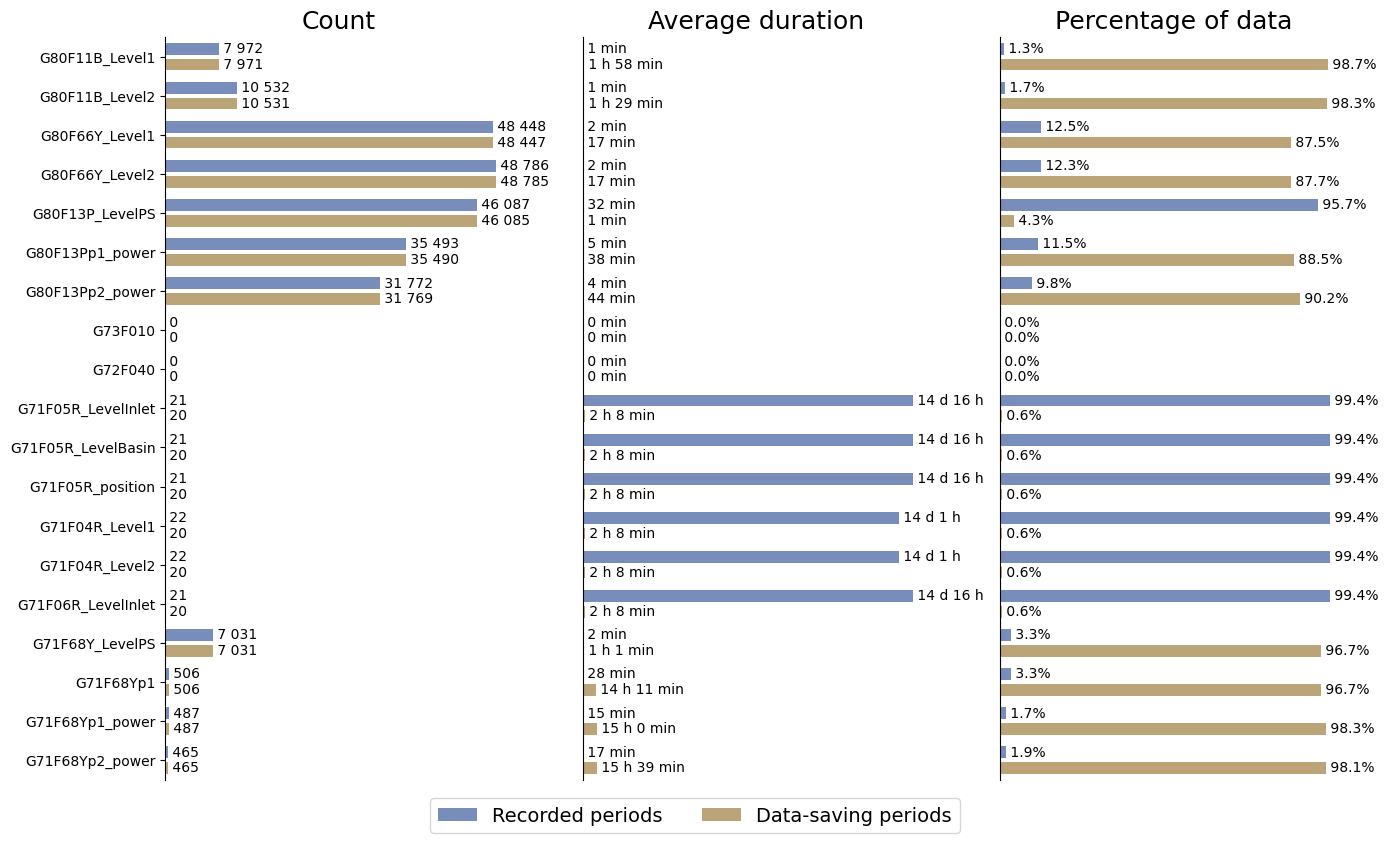

In [20]:
# Plot with error bars
fig, axs = plt.subplots(1, 3, figsize=(14, 8))

colors = ['#5671A9', '#A98E56']
segment_types = ['Recorded periods', 'Data-saving periods']

for sensor_index, sensor in enumerate(natural_sensor_order):
    for i, operation in enumerate(['count', 'average duration', 'percentage of data']):
        for j, segment_type in enumerate(segment_types):
            if operation == 'count':
                number = len(ffillings[sensor][segment_type])
                formatted_number = f" {number:,}".replace(',', ' ')
            
            elif operation == 'average duration':
                if len(ffillings[sensor][segment_type]) == 0:
                    number = 0
                else:
                    number = np.mean(ffillings[sensor][segment_type])
                days = number // (60 * 24)
                remaining_minutes = number % (60 * 24)
                hours = remaining_minutes // 60
                minutes = remaining_minutes % 60
                days, hours, minutes = int(days), int(hours), int(minutes)
                if days > 0:
                    #formatted_number = f" {days:,} d {hours} h {minutes} min"
                    formatted_number = f" {days:,} d"
                    if hours > 0:
                        formatted_number += f" {hours} h"

                elif hours > 0:
                    formatted_number = f" {hours:,} h {minutes} min"
                else:
                    formatted_number = f" {minutes} min"
                formatted_number = formatted_number.replace(',', ' ')
            else:
                if len(ffillings[sensor][segment_type]) == 0:
                    number = 0
                else:
                    number = sum(ffillings[sensor][segment_type]) / (sum(ffillings[sensor]['Recorded periods']) + sum(ffillings[sensor]['Data-saving periods'])) * 100
                formatted_number = f" {number:.1f}%"
                
            ax = axs[i]
            ax.set_title(operation.capitalize(), fontsize=18)
            # Use sensor index to position bars
            adjust_j = j - 0.5
            adj = 0.1
            adjust_j = adjust_j + adj if j == 0 else adjust_j - adj
            ax.barh(
                sensor_index * 2 + adjust_j,  # Adjust for double the sensors
                number,
                # adjust width of the bars
                height=0.6,
                color=colors[j],
                alpha=0.8,
                label=segment_type if sensor_index == 0 else ""  # Add label only once for legend
            )

            ax.text(number, sensor_index * 2 + adjust_j, formatted_number, ha='left', va='center')

# Add legend to the first subplot, invert the order of the legend
handles, labels = axs[0].get_legend_handles_labels()
# Reverse the order of handles and labels
handles = handles#[::-1]
labels = labels#[::-1]
# Create the legend with the reversed order
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=14, bbox_to_anchor=(0.5, -0.06))

for i, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_ylim(-1, len(natural_sensor_order) * 2 - 1)
    ax.invert_yaxis()
    # Set y-ticks to sensor names centered
    if i==0:
        ax.set_yticks([i * 2 for i in range(len(natural_sensor_order))])
        ax.set_yticklabels(natural_sensor_order)
    else:
        ax.set_yticks([])

plt.tight_layout()
plt.savefig(save_folder / 'recorded_vs_data_saving.png', bbox_inches='tight')
plt.show()

## Signal to noise ratio